# Geospatial Data Analysis
## Excercise 5.1

I use rasterio library to import the tiff files.

In [1]:
import rasterio
import os
import numpy as np
import matplotlib.pyplot as plt

green = rasterio.open(os.path.join(os.getcwd(), 'data', 'partA', 'green.tif'))
nir = rasterio.open(os.path.join(os.getcwd(), 'data', 'partA', 'nir.tif'))
gt = rasterio.open(os.path.join(os.getcwd(), 'data', 'partA', 'gt.tif'))

C:\Users\spele\Miniconda3\envs\geo\lib\site-packages\rasterio\__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Parse raster data into numpy arrays

In [ ]:
green = green.read(1)
nir = nir.read(1)
gt = gt.read(1)

Some indicative plots and views of the arrays

In [ ]:
print(np.shape(green))
plt.imshow(green)

In [ ]:
print(np.shape(nir))
plt.imshow(nir)

In [ ]:
print(np.shape(gt))
plt.imshow(gt)

I vectorize arrays

In [ ]:
green = green.reshape(-1)
nir = nir.reshape(-1)
gt = gt.reshape(-1)
green.shape

And then i join green and nir together so as to use them as independent variables of the machine learning algorithm.

In [ ]:
X = np.stack([green, nir], axis=1)
y = gt
print(X.shape)
print(gt.shape)

### Label encoder and normalisation

In this section I transform the y vector to 0,1 and print the numbers. I also normalise X inside [0,1]

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

In [ ]:
print("Number of ground - positive pixels: {}".format(list(y).count(0)))
print("Number of water - negative pixels: {}".format(list(y).count(1)))

In [ ]:
from sklearn import preprocessing
sc = preprocessing.StandardScaler()
X = sc.fit_transform(X)

### Train/ test split

I split to training and validation set by equally splitting water and ground pixels using the stratify parameter. I also decided to only use a part of the data (N) for training purposes given that the dataset is very large and at the same time it is very "easy" to achieve high accuracies even by limiting the training to a few hundreds of lines.

In [ ]:
N = 1000
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69, stratify=y)
X_train, X_test, y_train, y_test = X_train[:N,:], X_test[:N,:], y_train[:N], y_test[:N]

### Imports

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import pandas as pd

### Hyper parameter tuning

At first we train the classifiers using the GridSearch algorithm so as to decide the best hyperparameter values based on accuracy. The Gaussian Naive bayes classifier has no significant parameters to tune.

In [13]:
#Set the parameters of each model by cross-validation gridsearch
algorithms = [KNeighborsClassifier(), Perceptron(), GaussianNB()]
tuned_parameters = [{'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15], 'weights': ['uniform', 'distance']},
                    {'penalty':['l2','l1','elasticnet', None], 'early_stopping':[True, False]},
                    {'priors':[None, [0.5,0.5], [0.1, 0.9], [0.000001,0.99999], [0.000000001,0.99999999]]}]

best_scores=[]
params=[]
#Below I locate the best svm classifiers for each kernel and the best knn classifier and compute their score 
#on the test set 
for (a, tp) in list(zip(algorithms, tuned_parameters)):
    print("\n\nTuning hyper-parameters, based on accuracy for:\n", tp)
    clf = GridSearchCV(a, tp, cv = 5, scoring = 'accuracy', n_jobs=-1)
    clf.fit(X_train, y_train)
    print("Mean performance of each parameter combination based on Cross Validation")
    performance = pd.DataFrame(clf.cv_results_['params'])
    performance["Score"] = clf.cv_results_['mean_test_score']
    print(performance)
    print("\nBest parameters set found on training set:\n")
    print(clf.best_params_)
    params.append(clf.best_params_)
    print("\nThe scores are computed on the full evaluation set.\n")
    #evaluate and store scores of estimators of each category on validation set
    score = clf.score(X_test,y_test)
    print("score:", score)
    best_scores.append(score)
nb = GaussianNB()
nb.fit(X_train, y_train)
final_scores = dict(zip(['kNN','Perceptron','Gaussian Naive Bayes'], best_scores))
print("\n\nThe best accuracies achieved by the 3 algorithms are:", final_scores)



Tuning hyper-parameters, based on accuracy for:
 {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15], 'weights': ['uniform', 'distance']}
Mean performance of each parameter combination based on Cross Validation
    n_neighbors   weights  Score
0             1   uniform  0.997
1             1  distance  0.997
2             3   uniform  0.997
3             3  distance  0.997
4             5   uniform  0.996
5             5  distance  0.996
6             7   uniform  0.996
7             7  distance  0.997
8             9   uniform  0.997
9             9  distance  0.997
10           11   uniform  0.996
11           11  distance  0.996
12           13   uniform  0.996
13           13  distance  0.996
14           15   uniform  0.996
15           15  distance  0.996

Best parameters set found on training set:

{'n_neighbors': 1, 'weights': 'uniform'}

The scores are computed on the full evaluation set.

score: 1.0


Tuning hyper-parameters, based on accuracy for:
 {'penalty': ['l2', 'l1', 'elasti

### Evaluation

In this section I only keep the best classifiers as selected from the tuning process and evaluate them on all classification metrics except for accuracy. I resplit and this time I train all over the 70% of data. I prefered a 3-kNN as it is considered to be more robust than 1-kNN which is vulnerable to overfitting. I also set the early stopping to True for the perceptron algorithm as decided in the tunung process.

kNN 

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000    223403
           1    1.00000   1.00000   1.00000     76597

    accuracy                        1.00000    300000
   macro avg    1.00000   1.00000   1.00000    300000
weighted avg    1.00000   1.00000   1.00000    300000

Confusion matrix, without normalization
[[223403      0]
 [     0  76597]]
True Positives: 223403, False Positives: 0, True Negatives: 76597, False Negatives: 0 


NB 

              precision    recall  f1-score   support

           0    0.99757   0.99990   0.99873    223403
           1    0.99970   0.99290   0.99629     76597

    accuracy                        0.99811    300000
   macro avg    0.99863   0.99640   0.99751    300000
weighted avg    0.99811   0.99811   0.99811    300000

Confusion matrix, without normalization
[[223380     23]
 [   544  76053]]
True Positives: 223380, False Positives: 23, True Negatives: 76053, False Negatives: 544 


Perc

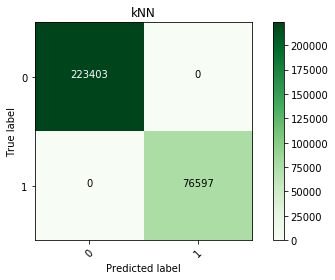

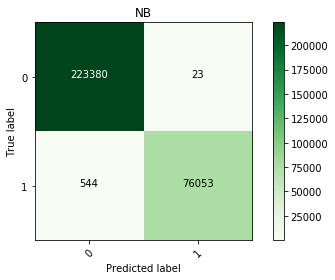

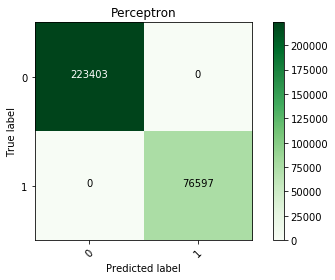

In [14]:
###############################################################################
# Evaluation with various classification metrics (classification report)
###############################################################################
from confusion_matrix import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69, stratify=y)
#X_train, X_test, y_train, y_test = X_train[:N,:], X_test[:N,:], y_train[:N], y_test[:N]

models = {'kNN': KNeighborsClassifier(n_neighbors=3),
          'NB': GaussianNB(priors=[0.1, 0.9]),
          'Perceptron': Perceptron(early_stopping=True)}
# Create scores dictionary for each algorithm
scores=[]
mdl=[]
results=[]
for model in models.keys():
    clf = models[model]
    clf.fit(X_train,  y_train)
    mdl.append(model)
    y_pred = clf.predict(X_test)
    results.append((clf.score(X_test, y_test), y_pred))
    print (model, "\n")
    print(metrics.classification_report(y_test, y_pred, digits=5))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plot_confusion_matrix(cm, classes=[0,1], title=model, cmap=plt.cm.Greens)
    print("True Positives: {}, False Positives: {}, True Negatives: {}, False Negatives: {} \n\n".format(cm[0,0], cm[0,1], cm[1,1], cm[1,0]))

I also plotted confusion matrices in order to be able to retrieve the TPs, TNs, FPs, TPs as required from the presentation of this excercise. 


### Comments

1. Main results: 

    The problem is simple enough to be solved almost perfectly by simple ML algorithms. The kNN  and the perceptron algorithms for example give a flawless result. Setting the early_stopping parameter as True was of great importance in order to achive this result with the perceptron algorithm.

2. Types of errors:

    - TPs are considered as the positive predictions (prediction = 0 = ground) that were correct (ground truth = 0 = ground)
    - FPs are considered as the positive predictions (prediction = 0 = ground) that weren't correct (ground truth = 1 = water)
    - TNs are considered as the negative predictions (prediction = 1 = water) that were correct (ground truth = 1 = water)
    - FNs are considered as the negative predictions (prediction = 1 = water) that weren't correct (ground truth = 0 = ground) <br><br>

    These types of errors help us identify the performance of our models in a more concise way and depending on the problem they might have different importance level. For example in case where positive means positive to cancer a false negative prediction by the model proves to be fatal for the patient. However false positive could create some false worries and concerns that will are soon to be proved wrong by further medical examinations and doctors. In our case of course it does not really matter what type of error the model commits however we can draw conclusions on the balancifg of its decisions.

3. Precision & recall:

    It usually occurs that algorithms tend to to favor a particular class, which means that they mainly commit errors of mainly one type (either FPs or FNs). Thus, we can see that the Gaussian Naive Bayes algorithm tends to favor class 0 (ground pixels). This seems normal given that there exist many more pixels labeled as ground which assigns a higher priors to the distribution of the ground pixels and even if I tried to change the priors, not much improvement occured. This behaviour of a model is vital to be examined in case that one class is more important to be predicted than another (e.g deadly disease detection such as cancer) or when classes are heavily imbalanced. It is also obvious that such behaviour cannot be depicted by the accuracy measure, and therefore we need more sophisticated metrics. These metrics are **precision** and **recall** which refer to scoring concerning each seperate class. <br><br>
 $$ recall = \frac{TP}{TP+FN} $$ <br>
 $$ precision =  \frac{TP}{TP+FN} $$  
For example high recall score for one class means that the model tends to locate every single occurence of this particular class in the sample and labels it correctly. However this is not enough as an evaluation metric if we imagine a model that always predicts this class for any input. This deficit is solved by the precision metric that measures the ratio of correct positive prediction over the total number of predictions. F1 score is the harmonic mean of the abovementioned metrics and is a more generic metric that evaluates the models much more accurately than the accuracy metric. These metrics prove to be very useful mainly when we deal with heavily imbalanced datasets or unequally important classes.